In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [2]:
import ktrain
from ktrain import text

In [3]:
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from IPython.display import Markdown
from IPython.display import display

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [4]:
import json

data = json.load(open("./data/dataset.json", "r"))

data = pd.DataFrame(data)
data.sample(10)

,text,author_id,label,created_at,retweet_count,reply_count,like_count,quote_count,in_reply_to_user_id
182913,@BobBoudrot He didn't and hasn't locked down t...,3143294376,fake,2020-04-20T00:25:58.000Z,0,1,0,0,False
13448,COMMENTARY: Treating Liver Disease During COVI...,2276572748,real,2020-05-15T16:13:32.000Z,0,0,0,0,True
188939,What are the symptoms of COVID-19? \n\nPreside...,1082924334639833088,real,2020-03-12T02:21:12.000Z,0,0,0,0,True
6975,"How to lead, manage and recruit your #team rem...",214403744,real,2020-05-29T10:24:07.000Z,0,0,1,0,True
13877,"Postponed Surgeries Resume, Stretching Hospita...",940613966962806784,real,2020-06-01T17:41:06.000Z,0,0,0,0,True
150254,We aren’t going to do contact testing. We aren...,1172982758571945990,real,2020-05-01T23:53:29.000Z,0,0,0,0,True
79574,Don't mess with Prestige Ameritech's Mike Bowe...,593813785,real,2020-05-14T18:38:00.000Z,0,1,6,0,False
180330,@Millie__Weaver I have no idea if this is accu...,706562460942073857,fake,2020-02-03T14:44:34.000Z,0,0,0,0,False
212444,@philosophequeer I would also like to know,45191927,real,2020-03-28T12:46:16.000Z,0,0,0,0,False
91254,@mohammadaqib__ shitter parade krdo🥺 begairat ...,1127510945406656512,real,2020-07-01T13:48:22.000Z,0,0,0,0,False


In [5]:
test_data = data.groupby("label").sample(frac=0.2)
data = data.drop(index=test_data.index)

In [6]:
data.text.str.split().apply(len).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

count    177151.000000
mean         25.564597
std          14.753490
min           1.000000
25%          12.000000
50%          23.000000
75%          38.000000
90%          46.000000
95%          50.000000
max         106.000000
Name: text, dtype: float64

In [7]:
data.label.value_counts()

real    168620
fake      8531
Name: label, dtype: int64

In [8]:
trn, val, preproc = text.texts_from_df(
    data,
    text_column = "text",
    label_columns="label",
    maxlen=50,
    ngram_range=1,
    random_state=41,
    preprocess_mode="standard"
)

['fake', 'real']
        fake  real
81057    0.0   1.0
14435    0.0   1.0
216678   0.0   1.0
41953    0.0   1.0
23075    0.0   1.0
['fake', 'real']
        fake  real
208535   0.0   1.0
37216    0.0   1.0
77636    0.0   1.0
151847   0.0   1.0
19309    0.0   1.0
language: en
Word Counts: 249802
Nrows: 159435
159435 train sequences
train sequence lengths:
	mean : 26
	95percentile : 49
	99percentile : 54
x_train shape: (159435,50)
y_train shape: (159435, 2)
Is Multi-Label? False
17716 test sequences
test sequence lengths:
	mean : 26
	95percentile : 49
	99percentile : 54
x_test shape: (17716,50)
y_test shape: (17716, 2)


In [9]:
model = text.text_classifier('bigru', trn , preproc=preproc)

done.


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      6000000     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 50, 300)     0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 50, 160)      183360      ['spatial_dropout1d[0][0]']  

In [11]:
learner = ktrain.get_learner(model, 
                             train_data=trn, 
                             val_data=val, 
                             batch_size=128)

In [12]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
1246/1246 [==============================] - 147s 116ms/step - loss: 0.3485 - accuracy: 0.9459
Epoch 2/1024
1246/1246 [==============================] - 25s 20ms/step - loss: 1.5289 - accuracy: 0.9348


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 7.19E-05
	Min numerical gradient (purple): 1.76E-02
	Min loss divided by 10 (omitted from plot): 3.61E-03


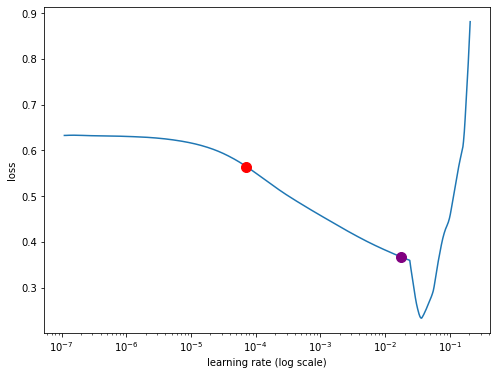

In [13]:
learner.lr_plot(suggest=True)

In [14]:
import gc
gc.collect()

12676

In [15]:
# 2e-5 is one of the LRs  recommended by Google and is consistent with the plot above.
learner.fit_onecycle(7.19E-05, 5)



begin training using onecycle policy with max lr of 7.19e-05...
Epoch 1/5
1246/1246 [==============================] - 185s 147ms/step - loss: 0.2878 - accuracy: 0.9506 - val_loss: 0.1802 - val_accuracy: 0.9525
Epoch 2/5
1246/1246 [==============================] - 148s 119ms/step - loss: 0.1463 - accuracy: 0.9567 - val_loss: 0.0901 - val_accuracy: 0.9747
Epoch 3/5
1246/1246 [==============================] - 146s 117ms/step - loss: 0.0742 - accuracy: 0.9777 - val_loss: 0.0685 - val_accuracy: 0.9797
Epoch 4/5
1246/1246 [==============================] - 152s 122ms/step - loss: 0.0567 - accuracy: 0.9828 - val_loss: 0.0642 - val_accuracy: 0.9818
Epoch 5/5
1246/1246 [==============================] - 146s 117ms/step - loss: 0.0505 - accuracy: 0.9847 - val_loss: 0.0630 - val_accuracy: 0.9825


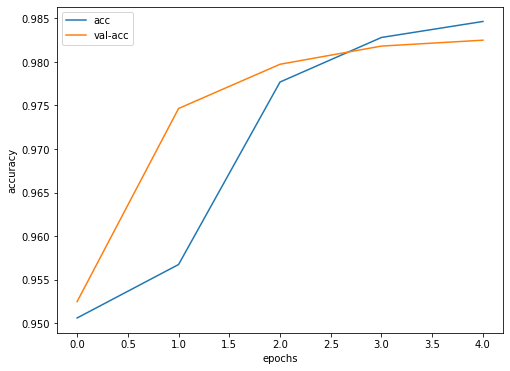

In [16]:
plt.plot(learner.history.history["accuracy"])
plt.plot(learner.history.history["val_accuracy"])
plt.legend(["acc", "val-acc"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

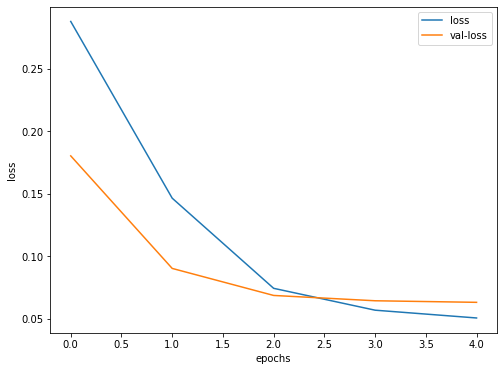

In [17]:
plt.plot(learner.history.history["loss"])
plt.plot(learner.history.history["val_loss"])
plt.legend(["loss", "val-loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [18]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [19]:
probs = predictor.predict_proba(test_data["text"].values)
probs[:5]

array([[0.01774224, 0.9822578 ],
       [0.99544513, 0.00455485],
       [0.9971462 , 0.00285381],
       [0.99398863, 0.00601138],
       [0.99660957, 0.00339048]], dtype=float32)

In [20]:
y = (test_data.label == "fake")
y.head()

189738    True
182502    True
193860    True
193817    True
193629    True
Name: label, dtype: bool

In [21]:
import metrics as mmetrics

In [22]:
y = y.values.reshape((-1, 1))

perfs = mmetrics.get_performance_metrics(y, probs[:, :1], ["BiGRU"])
perfs

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
BiGRU,1511,42062,93,622,0.984,0.048,0.708,0.998,0.942,0.985,0.971,0.809,0.5
